# Data Modeling

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from time import time
import itertools

# Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import accuracy_score

# Import supplementary visualization code visuals.py
import visuals as vs # source: Udacity

# Import the three supervised learning models from sklearn
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_predict, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier

from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier

from sklearn.metrics import plot_roc_curve

In [2]:
# read in the csv files
offer_response = pd.read_csv('data/offer_response.csv')
user = pd.read_csv('data/profile_cleaned.csv')

In [3]:
# Merge profile and number of offers completed
df = pd.merge(offer_response, 
             user, 
             how='left', 
             on=['person']).dropna().replace({True:1,False:0}).drop(columns=['person'])

In [4]:
bogo = df[df.offer_type=='discount']

In [5]:
# Convert categorical variables into dummy variables
clean_bogo = pd.get_dummies(bogo, columns=['gender']).drop_duplicates().drop(columns=['offer_type'])

In [13]:
print(clean_bogo[clean_bogo.completed_offer==False].shape[0])
print(clean_bogo[clean_bogo.completed_offer==True].shape[0])

2799
7487


In [6]:
# Split features and dependent variable into training and test sets
y = clean_bogo['completed_offer']
X = clean_bogo.drop(['completed_offer'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state = 42)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 8228 samples.
Testing set has 2058 samples.


In [7]:
# feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
# TODO explain how the supervised models are chosen

In [22]:
# Initiate models
svc = SVC(random_state=42)
mlp = MLPClassifier(random_state=42)
gb = GradientBoostingClassifier()
rfc = RandomForestClassifier(max_depth=6, max_features=3, n_estimators=50)


svc.fit(X_train, y_train)
mlp.fit(X_train, y_train)
gb.fit(X_train, y_train)
rfc.fit(X_train, y_train)

# Print the results 

/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6, max_features=3,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

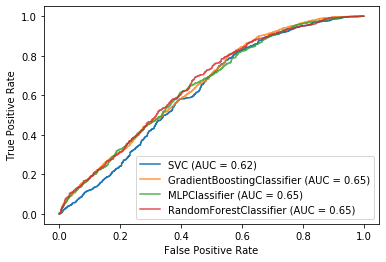

In [23]:
svc_disp = plot_roc_curve(svc, X_test, y_test)
ax = plt.gca()
gb_disp = plot_roc_curve(gb, X_test, y_test,ax=ax, alpha=0.8)
mlp_disp = plot_roc_curve(mlp, X_test, y_test, ax=ax, alpha=0.8)
rfc_disp = plot_roc_curve(rfc, X_test, y_test, ax=ax, alpha=0.8)
# gb_disp.plot(ax=ax, alpha=0.8)
plt.show()

In [36]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score


# Initialize the classifier
clf = DecisionTreeClassifier()

# Create the parameters list you wish to tune, using a dictionary if needed.
parameters = {
    "max_depth": [2,3,4,5,6,10],
    "max_features": [2,3,4,5,6],
    "min_samples_leaf":[1,2,3],
    "min_samples_split":[2,3]
    }

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, cv=3, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_
grid_fit.best_params_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Unoptimized model
------
Accuracy score on testing data: 0.5209
F-score on testing data: 0.6711

Optimized Model
------
Final accuracy score on the testing data: 0.7464
Final F-score on the testing data: 0.7828


In [37]:
print(grid_fit.best_params_)

{'max_depth': 3, 'max_features': 6, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [18]:
rfc_optimized = RandomForestClassifier(max_depth=6, max_features=3, n_estimators=50)

In [20]:
rfc_optimized.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6, max_features=3,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

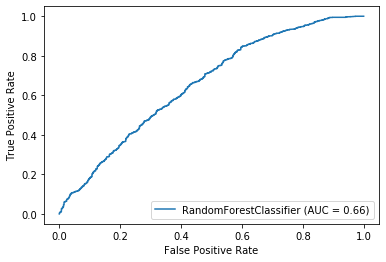

In [21]:
rfc_op_disp = plot_roc_curve(rfc_optimized, X_test, y_test)
plt.show()

Confusion matrix, without normalization
[[  91  486]
 [  40 1441]]
Normalized confusion matrix
[[0.16 0.84]
 [0.03 0.97]]


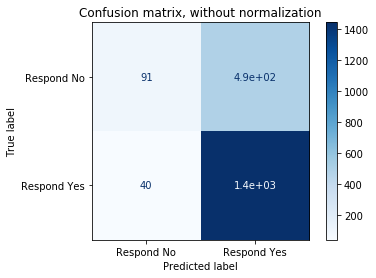

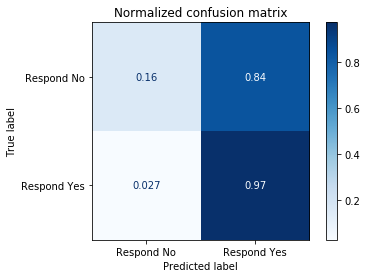

In [25]:
from sklearn.metrics import plot_confusion_matrix
class_names = ['Respond No', 'Respond Yes']
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(rfc_optimized, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [ ]:
# imbalanced classes research
# https://github.com/scikit-learn-contrib/imbalanced-learn/blob/master/examples/ensemble/plot_comparison_ensemble_classifier.py